In [9]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
class LandmarksDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [11]:
PATH = 'data'
actions = np.array(os.listdir(PATH))
label_map = {label: num for num, label in enumerate(actions)}

landmarks, labels = [], []
for action in actions:
    action_path = os.path.join(PATH, action)
    sequences = os.listdir(action_path)
    for sequence in sequences:
        temp = []
        sequence_path = os.path.join(action_path, sequence)
        frames = sorted(os.listdir(sequence_path))
        for frame in frames:
            npy_path = os.path.join(sequence_path, frame)
            if os.path.isfile(npy_path):
                npy = np.load(npy_path)
                temp.append(npy)
        if temp:
            landmarks.append(temp)
            labels.append(label_map[action])

X = np.array(landmarks)
Y = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=34, stratify=Y)

train_dataset = LandmarksDataset(X_train, Y_train)
test_dataset = LandmarksDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerModel, self).__init__()
        self.dense1 = nn.Linear(input_dim, 128)
        self.encoder_block1 = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=128)
        self.encoder_block2 = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=128)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dense2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dense1(x)
        x = x.permute(1, 0, 2)  # For multihead attention
        x = self.encoder_block1(x)
        x = self.encoder_block2(x)
        x = x.permute(1, 2, 0)  # For pooling
        x = self.global_avg_pool(x).squeeze(-1)
        x = F.relu(self.dense2(x))
        x = self.dropout(x)
        return F.softmax(self.out(x), dim=1)

In [17]:

input_shape = (30, 126)
num_classes = len(actions)
model = TransformerModel(input_dim=input_shape[1], num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
history = {'epoch': [], 'loss': [], 'accuracy': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = metrics.accuracy_score(all_labels, all_preds)
    history['epoch'].append(epoch + 1)
    history['loss'].append(running_loss / len(train_loader))
    history['accuracy'].append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {accuracy}')


Epoch 1/300, Loss: 3.5502204224467278, Accuracy: 0.1866579033848176
Epoch 2/300, Loss: 3.4368485858043036, Accuracy: 0.2803154781465659
Epoch 3/300, Loss: 3.392495642105738, Accuracy: 0.2671705553729872
Epoch 4/300, Loss: 3.3365229989091554, Accuracy: 0.3766020374630299
Epoch 5/300, Loss: 3.2742646858096123, Accuracy: 0.3864607295432139
Epoch 6/300, Loss: 3.2588301673531532, Accuracy: 0.47683207361156754
Epoch 7/300, Loss: 3.1865208198626838, Accuracy: 0.49162011173184356
Epoch 8/300, Loss: 3.1755757654706636, Accuracy: 0.5632599408478475
Epoch 9/300, Loss: 3.1360826243956885, Accuracy: 0.5372987183700296
Epoch 10/300, Loss: 3.137402350703875, Accuracy: 0.5386132106473874
Epoch 11/300, Loss: 3.131388269364834, Accuracy: 0.5103516266841932
Epoch 12/300, Loss: 3.1396722570061684, Accuracy: 0.5806769635228393
Epoch 13/300, Loss: 3.091818536321322, Accuracy: 0.5372987183700296
Epoch 14/300, Loss: 3.129250285526117, Accuracy: 0.5695037791652974
Epoch 15/300, Loss: 3.0788483594854674, Accura

In [18]:
import json 

torch.save(model.state_dict(), 'transformer_model.pth')

with open('training_history.json', 'w') as f:
    json.dump(history, f)

Accuracy: 0.8843626806833115


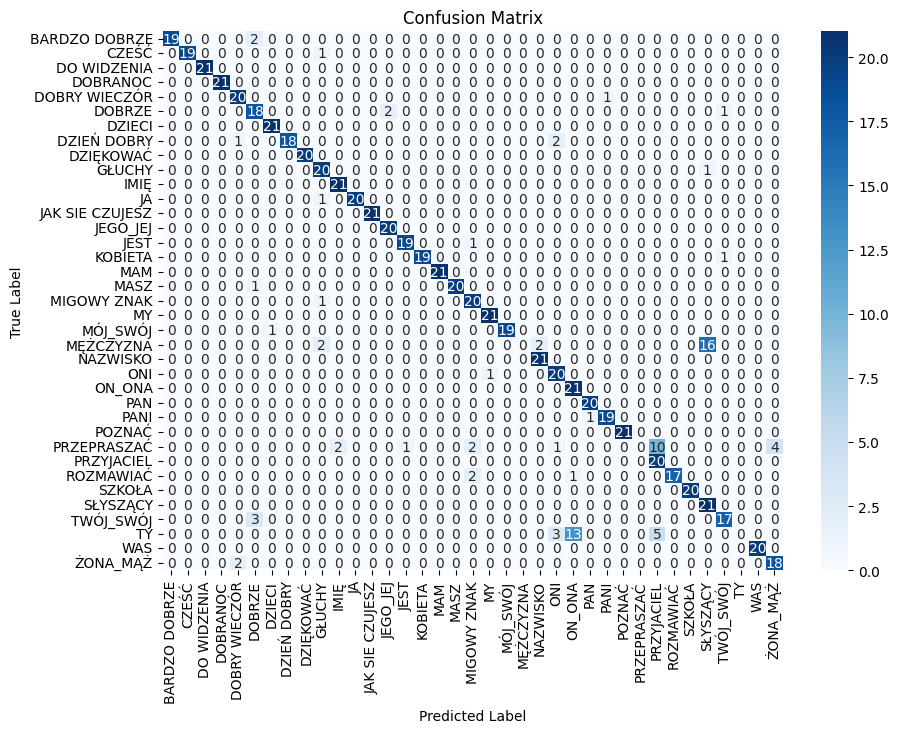

In [19]:

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = metrics.accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

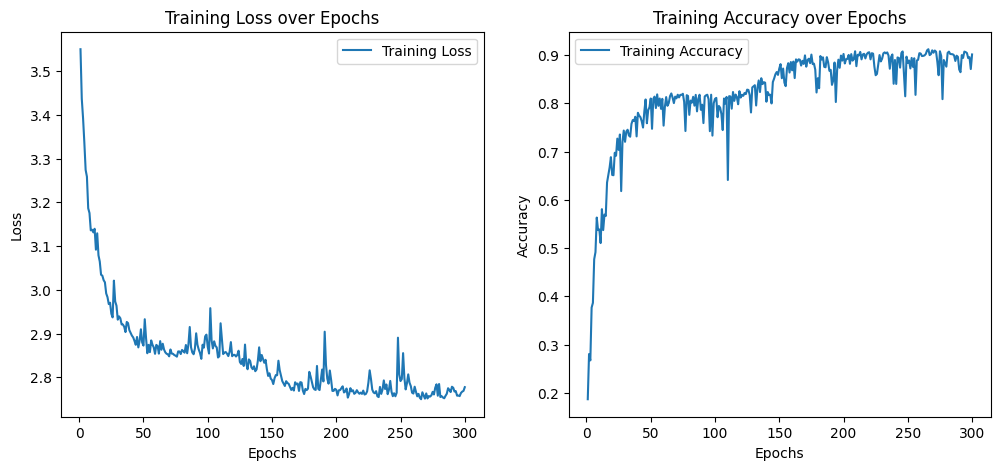

In [20]:
epochs = history['epoch']
loss = history['loss']
accuracy = history['accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()
